In [2]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/kaggle/working/6D_pose"   #Modify here for kaggle
branch = "pose_rgbd"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    # %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 701, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 701 (delta 6), reused 14 (delta 4), pack-reused 674 (from 1)
Receiving objects: 100% (701/701), 10.19 MiB | 35.15 MiB/s, done.
Resolving deltas: 100% (388/388), done.
Cloned https://github.com/fraco03/6D_pose.git to /kaggle/working/6D_pose


In [ ]:
%cd ..
!gdown --fuzzy https://drive.google.com/file/d/1zNthSyiBdPUfn7BmUKPbKoGgQdG1vGnS/view?usp=drive_link -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip
%cd 6D_pose

In [ ]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

In [3]:
# dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle
# dataset_root = "../../Linemod_preprocessed"
# dataset_root = "/content/Linemod_preprocessed"
# dataset_root = "/kaggle/working/Linemod_preprocessed"
dataset_root = "/kaggle/input/line-mode/Linemod_preprocessed"

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")



✅ Setup complete!
📁 Dataset path: /kaggle/input/line-mode/Linemod_preprocessed


In [ ]:
!pip install plyfile
from src.pose_rgbd.dataset import LineModPoseDepthDataset
import torch
from src.pose_rgbd.model import RGBDRotationModel
from utils.linemod_config import get_linemod_config
import numpy as np
import torch
from src.pose_rgbd.loss import MultiObjectPointMatchingLoss
import torch.nn as nn

linemod_config = get_linemod_config(dataset_root)

✅ LineModConfig initialized: /kaggle/input/line-mode/Linemod_preprocessed
 Loaded LineModPoseDepthDataset
   Split: train (Ratio: 0.8)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 12610
 Loaded LineModPoseDepthDataset
   Split: test (Ratio: 0.8)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3163


In [ ]:
train_dataset = LineModPoseDepthDataset(
    root_dir=dataset_root,
    split="train"
)

test_dataset = LineModPoseDepthDataset(
    root_dir=dataset_root,
    split="test"
)

In [6]:
sample = train_dataset[0]

print(f"Sample keys: {sample.keys()}")
print(f"Depth shape: {sample['depth'].shape}")
print(f"RGB shape: {sample['image'].shape}")

Sample keys: dict_keys(['image', 'depth', 'img_id', 'img_path', 'rotation', 'translation', '3D_center', 'object_id', 'class_idx', 'cam_K', 'bbox'])
Depth shape: torch.Size([1, 224, 224])
RGB shape: torch.Size([3, 224, 224])


In [ ]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
all_model_points = []
NUM_POINTS = 500  # Number of points to sample from each model
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
for obj_id in VALID_OBJ_IDS:
    model_points = linemod_config.get_model_3d(obj_id, unit='m')  # (N, 3)
    if model_points.shape[0] >= NUM_POINTS:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=False)
    else:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=True)
    model_points = model_points[choice, :]
    all_model_points.append(torch.tensor(model_points, dtype=torch.float32))
all_model_points = torch.stack(all_model_points, dim=0)  # (Num_Classes, NUM_POINTS, 3)
all_model_points = all_model_points.to(device)

max_obj_id = max(VALID_OBJ_IDS)
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 

# Create a lookup table: obj_id -> index
obj_id_to_idx = torch.full((max_obj_id + 1,), -1, dtype=torch.long, device=device)
for idx, obj_id in enumerate(VALID_OBJ_IDS):
    obj_id_to_idx[obj_id] = idx

In [ ]:
model = RGBDRotationModel(pretrained=True)

if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

model = model.to(device)

backbone_params = [p for n, p in model.named_parameters() if 'backbone' in n]
head_params = [p for n, p in model.named_parameters() if 'rot_head' in n]

# Loss function and optimizer
criterion = MultiObjectPointMatchingLoss(all_model_points)
optimizer = torch.optim.AdamW([
    {
        'params': backbone_params, 
        'lr': 3e-5  # Low: preserves knowledge, adapts only depth
    },
    {
        'params': head_params,     
        'lr': 1e-3  # High: learn to predict quaternions from scratch
    }
], weight_decay=1e-4) # Global regularization

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       # We want to minimize the validation loss
    factor=0.5,       # Halve the learning rate when triggered
    patience=3,       # Wait 3 epochs of stagnation (small dataset -> low patience)
    
    min_lr=1e-7
)

🔥 Using 2 GPU!


In [37]:
from torch.utils.data import DataLoader

batch_size = 32  #double GPU

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True,
    persistent_workers=True,
    drop_last=True)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    pin_memory=True,
    persistent_workers=True,
    num_workers=4)

In [38]:
from tqdm import tqdm
import os
import datetime
from itertools import islice
from datetime import datetime

# Load best model

# Ciclo di training
num_epochs = 60
best_test_loss = float('inf')
# checkpoint_dir = "checkpoints"
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# checkpoint_dir = f'/content/drive/MyDrive/runs/POINT_MATCH_{timestamp}' # modify here for kaggle
checkpoint_dir = f'/kaggle/working/POINT_MATCH_{timestamp}'
os.makedirs(checkpoint_dir, exist_ok=True)
# val_batches_limit = 50

# Track losses for plotting
train_losses = []
test_losses = []

batch_size = 32

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    for batch in train_pbar:
        rgb = batch['image'].to(device)  # RGB image (B, 3, H, W)
        depth = batch['depth'].to(device)  # Depth (B, 1, H, W)
        rotations = batch['rotation'].to(device)  # GT quaternion (B, 4)
        obj_ids = batch['object_id'].to(device)  # Object IDs (B,)
        obj_ids = obj_id_to_idx[obj_ids]  # Map to indices (B,)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(rgb, depth)

        # Calcolo della loss
        loss = criterion(outputs, rotations, obj_ids)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_pbar.set_postfix({'loss': epoch_loss / (train_pbar.n + 1)})


    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0.0

    val_pbar = tqdm(test_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Validating")
    count_batches = 0
    with torch.no_grad():
        for batch in val_pbar:
            rgb = batch['image'].to(device)
            depth = batch['depth'].to(device)
            rotations = batch['rotation'].to(device)
            obj_ids = batch['object_id'].to(device)  # Object IDs (B,)
            obj_ids = obj_id_to_idx[obj_ids].to(device)  # Map to indices (B,)

            outputs = model(rgb, depth)
            loss = criterion(outputs, rotations, obj_ids)
            test_loss += loss.item()
            val_pbar.set_postfix({'loss': test_loss / (val_pbar.n + 1)})
            count_batches+=1

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

    # Step the scheduler
    scheduler.step(avg_test_loss)

    

    # Save checkpoint if test loss improved
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': avg_test_loss,
        }, checkpoint_path)
        print(f"✅ Checkpoint saved! Best Test Loss: {best_test_loss:.4f}")
    else:
        print(f"⚠️  No improvement. Best Test Loss: {best_test_loss:.4f}")

    current_lr = optimizer.param_groups[0]['lr']

    if current_lr < 1e-6:
        print("⏹️ Early stopping due to low LR")
        break

Epoch [1/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.06it/s, loss=0.0302]


Epoch [1/60], Test Loss: 0.0299
✅ Checkpoint saved! Best Test Loss: 0.0299


Epoch [2/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.12it/s, loss=0.0217]


Epoch [2/60], Test Loss: 0.0215
✅ Checkpoint saved! Best Test Loss: 0.0215


Epoch [3/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.12it/s, loss=0.0183]


Epoch [3/60], Test Loss: 0.0181
✅ Checkpoint saved! Best Test Loss: 0.0181


Epoch [4/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s, loss=0.0164]


Epoch [4/60], Test Loss: 0.0162
✅ Checkpoint saved! Best Test Loss: 0.0162


Epoch [5/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.12it/s, loss=0.0157]


Epoch [5/60], Test Loss: 0.0155
✅ Checkpoint saved! Best Test Loss: 0.0155


Epoch [6/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.0147]


Epoch [6/60], Test Loss: 0.0145
✅ Checkpoint saved! Best Test Loss: 0.0145


Epoch [7/60] - Validating: 100%|██████████| 99/99 [00:23<00:00,  4.13it/s, loss=0.0143]


Epoch [7/60], Test Loss: 0.0142
✅ Checkpoint saved! Best Test Loss: 0.0142


Epoch [8/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.10it/s, loss=0.0134]


Epoch [8/60], Test Loss: 0.0132
✅ Checkpoint saved! Best Test Loss: 0.0132


Epoch [9/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.0131]


Epoch [9/60], Test Loss: 0.0130
✅ Checkpoint saved! Best Test Loss: 0.0130


Epoch [10/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s, loss=0.0132]


Epoch [10/60], Test Loss: 0.0130
⚠️  No improvement. Best Test Loss: 0.0130


Epoch [11/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.0119]


Epoch [11/60], Test Loss: 0.0118
✅ Checkpoint saved! Best Test Loss: 0.0118


Epoch [12/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.0108] 


Epoch [12/60], Test Loss: 0.0107
✅ Checkpoint saved! Best Test Loss: 0.0107


Epoch [13/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.0115]


Epoch [13/60], Test Loss: 0.0114
⚠️  No improvement. Best Test Loss: 0.0107


Epoch [14/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.04it/s, loss=0.0115]


Epoch [14/60], Test Loss: 0.0114
⚠️  No improvement. Best Test Loss: 0.0107


Epoch [15/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.04it/s, loss=0.0111]


Epoch [15/60], Test Loss: 0.0110
⚠️  No improvement. Best Test Loss: 0.0107


Epoch [16/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s, loss=0.0104] 


Epoch [16/60], Test Loss: 0.0103
✅ Checkpoint saved! Best Test Loss: 0.0103


Epoch [17/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.011] 


Epoch [17/60], Test Loss: 0.0108
⚠️  No improvement. Best Test Loss: 0.0103


Epoch [18/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s, loss=0.0107] 


Epoch [18/60], Test Loss: 0.0106
⚠️  No improvement. Best Test Loss: 0.0103


Epoch [19/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.05it/s, loss=0.00985]


Epoch [19/60], Test Loss: 0.0098
✅ Checkpoint saved! Best Test Loss: 0.0098


Epoch [20/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.00956]


Epoch [20/60], Test Loss: 0.0095
✅ Checkpoint saved! Best Test Loss: 0.0095


Epoch [21/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.0102] 


Epoch [21/60], Test Loss: 0.0101
⚠️  No improvement. Best Test Loss: 0.0095


Epoch [22/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.00957]


Epoch [22/60], Test Loss: 0.0095
⚠️  No improvement. Best Test Loss: 0.0095


Epoch [23/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s, loss=0.00951]


Epoch [23/60], Test Loss: 0.0094
✅ Checkpoint saved! Best Test Loss: 0.0094


Epoch [24/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.00934]


Epoch [24/60], Test Loss: 0.0092
✅ Checkpoint saved! Best Test Loss: 0.0092


Epoch [25/60] - Validating: 100%|██████████| 99/99 [00:23<00:00,  4.14it/s, loss=0.0088] 


Epoch [25/60], Test Loss: 0.0087
✅ Checkpoint saved! Best Test Loss: 0.0087


Epoch [26/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.00906]


Epoch [26/60], Test Loss: 0.0090
⚠️  No improvement. Best Test Loss: 0.0087


Epoch [27/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.00895]


Epoch [27/60], Test Loss: 0.0089
⚠️  No improvement. Best Test Loss: 0.0087


Epoch [28/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.02it/s, loss=0.00868]


Epoch [28/60], Test Loss: 0.0086
✅ Checkpoint saved! Best Test Loss: 0.0086


Epoch [29/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.05it/s, loss=0.00935]


Epoch [29/60], Test Loss: 0.0093
⚠️  No improvement. Best Test Loss: 0.0086


Epoch [30/60] - Validating: 100%|██████████| 99/99 [00:23<00:00,  4.13it/s, loss=0.00875]


Epoch [30/60], Test Loss: 0.0087
⚠️  No improvement. Best Test Loss: 0.0086


Epoch [31/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s, loss=0.00908]


Epoch [31/60], Test Loss: 0.0090
⚠️  No improvement. Best Test Loss: 0.0086


Epoch [32/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.00838]


Epoch [32/60], Test Loss: 0.0083
✅ Checkpoint saved! Best Test Loss: 0.0083


Epoch [33/60] - Validating: 100%|██████████| 99/99 [00:23<00:00,  4.13it/s, loss=0.00915]


Epoch [33/60], Test Loss: 0.0091
⚠️  No improvement. Best Test Loss: 0.0083


Epoch [34/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.12it/s, loss=0.00836]


Epoch [34/60], Test Loss: 0.0083
✅ Checkpoint saved! Best Test Loss: 0.0083


Epoch [35/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.00865]


Epoch [35/60], Test Loss: 0.0086
⚠️  No improvement. Best Test Loss: 0.0083


Epoch [36/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.04it/s, loss=0.00816]


Epoch [36/60], Test Loss: 0.0082
✅ Checkpoint saved! Best Test Loss: 0.0082


Epoch [37/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.10it/s, loss=0.00796]


Epoch [37/60], Test Loss: 0.0079
✅ Checkpoint saved! Best Test Loss: 0.0079


Epoch [38/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.00784]


Epoch [38/60], Test Loss: 0.0078
✅ Checkpoint saved! Best Test Loss: 0.0078


Epoch [39/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.00853]


Epoch [39/60], Test Loss: 0.0084
⚠️  No improvement. Best Test Loss: 0.0078


Epoch [40/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.10it/s, loss=0.00784]


Epoch [40/60], Test Loss: 0.0078
⚠️  No improvement. Best Test Loss: 0.0078


Epoch [41/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  3.99it/s, loss=0.0079] 


Epoch [41/60], Test Loss: 0.0078
⚠️  No improvement. Best Test Loss: 0.0078


Epoch [42/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.00843]


Epoch [42/60], Test Loss: 0.0083
⚠️  No improvement. Best Test Loss: 0.0078


Epoch [43/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.0077] 


Epoch [43/60], Test Loss: 0.0076
✅ Checkpoint saved! Best Test Loss: 0.0076


Epoch [44/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.00735]


Epoch [44/60], Test Loss: 0.0073
✅ Checkpoint saved! Best Test Loss: 0.0073


Epoch [45/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.00736]


Epoch [45/60], Test Loss: 0.0073
✅ Checkpoint saved! Best Test Loss: 0.0073


Epoch [46/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.10it/s, loss=0.00708]


Epoch [46/60], Test Loss: 0.0070
✅ Checkpoint saved! Best Test Loss: 0.0070


Epoch [47/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.00it/s, loss=0.0072] 


Epoch [47/60], Test Loss: 0.0071
⚠️  No improvement. Best Test Loss: 0.0070


Epoch [48/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.00704]


Epoch [48/60], Test Loss: 0.0070
✅ Checkpoint saved! Best Test Loss: 0.0070


Epoch [49/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.10it/s, loss=0.00726]


Epoch [49/60], Test Loss: 0.0072
⚠️  No improvement. Best Test Loss: 0.0070


Epoch [50/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.09it/s, loss=0.00684]


Epoch [50/60], Test Loss: 0.0068
✅ Checkpoint saved! Best Test Loss: 0.0068


Epoch [51/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  3.99it/s, loss=0.00696]


Epoch [51/60], Test Loss: 0.0069
⚠️  No improvement. Best Test Loss: 0.0068


Epoch [52/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.05it/s, loss=0.00689]


Epoch [52/60], Test Loss: 0.0068
⚠️  No improvement. Best Test Loss: 0.0068


Epoch [53/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.06it/s, loss=0.00682]


Epoch [53/60], Test Loss: 0.0067
✅ Checkpoint saved! Best Test Loss: 0.0067


Epoch [54/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.07it/s, loss=0.00662]


Epoch [54/60], Test Loss: 0.0066
✅ Checkpoint saved! Best Test Loss: 0.0066


Epoch [55/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.11it/s, loss=0.00706]


Epoch [55/60], Test Loss: 0.0070
⚠️  No improvement. Best Test Loss: 0.0066


Epoch [56/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.06it/s, loss=0.00676]


Epoch [56/60], Test Loss: 0.0067
⚠️  No improvement. Best Test Loss: 0.0066


Epoch [57/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.02it/s, loss=0.00683]


Epoch [57/60], Test Loss: 0.0068
⚠️  No improvement. Best Test Loss: 0.0066


Epoch [58/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.08it/s, loss=0.00661]


Epoch [58/60], Test Loss: 0.0065
✅ Checkpoint saved! Best Test Loss: 0.0065


Epoch [59/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.00it/s, loss=0.00686]


Epoch [59/60], Test Loss: 0.0068
⚠️  No improvement. Best Test Loss: 0.0065


Epoch [60/60] - Validating: 100%|██████████| 99/99 [00:24<00:00,  4.06it/s, loss=0.00664]

Epoch [60/60], Test Loss: 0.0066
⚠️  No improvement. Best Test Loss: 0.0065


# Save losses and plots

In [ ]:
# Save losses
import pickle

losses_dict = {
    'train_losses': train_losses,
    'test_losses': test_losses
}

losses_path = os.path.join(checkpoint_dir, "losses.pkl")
with open(losses_path, 'wb') as f:
    pickle.dump(losses_dict, f)


## Show plot of losses

In [ ]:
from utils.plots import plot_losses
import pickle

# checkpoint_dir = f'/kaggle/working/POINT_MATCH_{timestamp}'
checkpoint_dir = f'./RGBD_final'
losses_pickle = checkpoint_dir + '/losses.pkl'

with open(losses_pickle, 'rb') as f:
    losses = pickle.load(f)
    train_losses = losses['train_losses']
    test_losses = losses['test_losses']
plot_losses(train_losses, test_losses)

# Visualize samples

In [1]:
import sys
sys.path.append('../..')

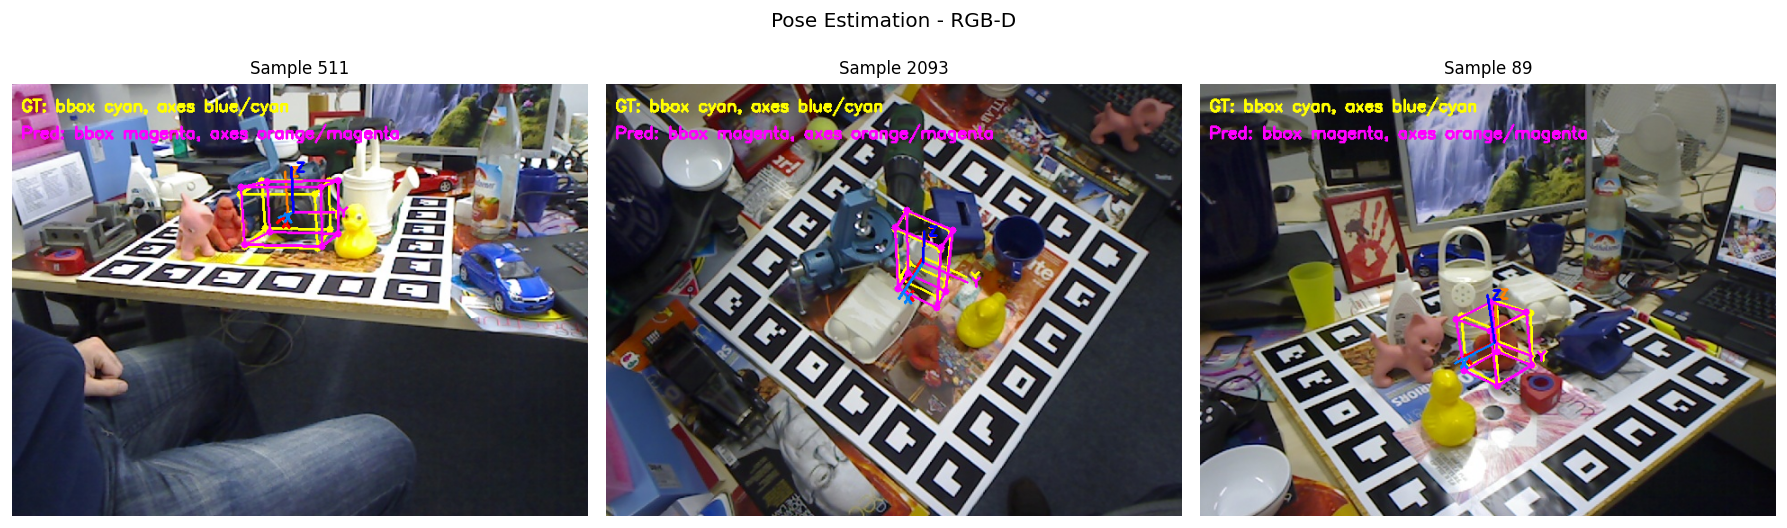

In [3]:
from src.pose_rgbd.visualize import visualize_RGBD_random_samples
import torch

dataset_root = "../../Linemod_preprocessed"
checkpoint_dir = "./RGBD_final"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_samples = 3

visualize_RGBD_random_samples(
    checkpoint_dir,
    dataset_root,
    device,
    num_samples=num_samples
)

# Evaluation

In [42]:
from src.pose_rgbd.evaluate import evaluate_RGBD
# MODEL_PATH = "./RGBD_run/best_model.pth"            # Path to the trained model
# DATASET_ROOT = "../../Linemod_preprocessed"  # Path to the Linemod dataset
# OUTPUT_PATH = "./RGBD_run/linemod_evaluation_report.csv"  # Path to save the evaluation report

MODEL_PATH = checkpoint_dir + "/best_model.pth"
DATASET_ROOT = dataset_root
OUTPUT_PATH = checkpoint_dir + "/report.csv"

df = evaluate_RGBD(
    model_path=MODEL_PATH,
    dataset_root=DATASET_ROOT,
    output_path=OUTPUT_PATH
)

df

📥 Loading 3D model points and diameters...
📦 Loading trained model...
📚 Preparing test dataset and dataloader...
 Loaded LineModPoseDepthDataset
   Split: test (Ratio: 0.8)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3163

🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating: 100%|██████████| 25/25 [03:08<00:00,  7.53s/batch]


📊 Evaluation report saved to /kaggle/working/POINT_MATCH_20251221_154456/report.csv


,Object ID,Object Name,Diameter (mm),Mean ADD (mm),Mean ADD-S (mm),Mean ADD-Rot (mm),Mean ADD-S-Rot (mm),ADD-0.1d Accuracy (%),ADD-S-0.1d Accuracy (%)
0,1,ape,102.098657,5.432197,1.976503,5.432473,1.976712,93.145161,100.0
1,2,benchvise,247.506242,7.796313,3.593347,7.793520,3.592246,98.760331,100.0
2,4,camera,172.492249,6.490071,2.556891,6.486839,2.554876,99.585062,100.0
3,5,can,201.403586,6.792139,2.658522,6.792662,2.658889,99.166667,100.0
4,6,cat,154.545518,5.706939,2.548579,5.706706,2.548426,99.152542,100.0
5,8,driller,261.471781,7.940766,3.834743,7.936336,3.831109,99.159664,100.0
6,9,duck,108.999201,5.396640,2.184947,5.395957,2.184613,95.617530,100.0
7,10,eggbox,164.627588,5.826799,2.153036,5.826536,2.153264,98.406375,100.0
8,11,glue,175.889334,5.692160,2.843530,5.692966,2.843760,99.588477,100.0
9,12,holepuncher,145.542875,5.281077,2.145028,5.280509,2.145061,97.983871,100.0
